In [369]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import random

## Global Variables

You can play around with `num_demand_points` and `coverage_radius` to see how the solution changes.

In [370]:
# Set the dimensions of the rectangular region
region_width = 100
region_height = 100

# Set the number of demand points
num_demand_points = 20

# Set the coverage radius of a UAV
coverage_radius = 30

# Graph config
figsize=(8,6)
label_font_size=12
node_size=500


## Data Generation
Data is generated with a random integer `x` and `y` coordinate between `0` and the bounds of the region (`region_width` and `region_height`).

In [371]:
# Create an empty graph
G = nx.Graph()

# Generate random positions for demand points within the rectangular region
demand_points = []
for i in range(num_demand_points):
    x = random.randint(0, region_width)
    y = random.randint(0, region_height)
    demand_points.append((x, y))
    G.add_node(i, pos=(x, y)) 

print ("G has", G.number_of_nodes(), "nodes")

G has 20 nodes


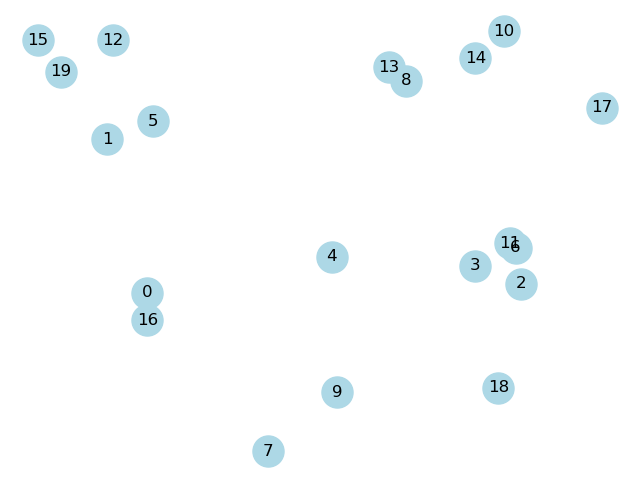

In [372]:
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=figsize)
nx.draw_networkx_labels(G, pos, font_size=label_font_size)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_size)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()

### Sets
- $N$ = set of demand points
- $M$ = set of flight position of UAVs

### Parameters
- $b^x_j$ = flight position of UAV $j$ on x-coordinate
- $b^y_j$ = flight position of UAV $j$ on y-coordinate
- $\alpha_{ij}$ = binary feasibility of UAV $j$ covering demand point $i$

### Decision Variables
$$y_j = 
\begin{cases}
1,\quad \text{ if UAV $j$ is used} \\
0,\quad \text{otherwise}
\end{cases}$$

$$x_{ij} = 
\begin{cases}
1,\quad \text{ if demand point $i$ is covered by UAV $j$} \\
0,\quad \text{otherwise}
\end{cases}
$$


$$ \forall i \in N \\ \forall j \in N$$



### Objective function
$$\begin{alignat}{3}
& \min \sum_{j \in M}y_j \\
& \text{s.t.} x_{ij} \le y_j \quad && \forall i \in N, \forall j \in M \\
& \sum_{j \in M} \alpha_{ij}x_{ij} \ge 1 \quad && \forall i \in N \\
& x_{ij} \in \{0, 1\} \quad && \forall i \in N, \forall j \in M \\
& y_j \in \{0, 1\} \quad && \forall j \in M

\end{alignat}$$

### Distance

Distance between each demand point is calculated using the Euclidean distance formula: $$\sqrt{(a^x_i - b^x_j)^2 + (a^y_i - b^y_j)^2}$$

$\alpha = 1$ if distance is less than or equal to the coverage radius, $0$ otherwise.

In [373]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Create a Gurobi model
model = gb.Model()

# Create decision variables x
x = {}
for i in G.nodes():
    for j in G.nodes():
        x[i,j] = model.addVar(vtype=gb.GRB.BINARY, name=f"x_{i,j}")

# Create decision variables y
y = {}
for node in G.nodes():
    y[node] = model.addVar(vtype=gb.GRB.BINARY, name=f"y_{node}")

# Set objective function
model.setObjective(gb.quicksum(y[node] for node in G.nodes()), gb.GRB.MINIMIZE)

# Add coverage constraints
for i in G.nodes():
    for j in G.nodes():
        model.addConstr(x[i,j] <= y[j], f"y_{i}_{j}")
for i in range(num_demand_points):
    model.addConstr(gb.quicksum(x[i,j] for j in range(num_demand_points) if euclidean_distance(demand_points[i], demand_points[j]) <= coverage_radius) >= 1, f"cover_{i}")


model.write('scp.lp')

# Optimize the model
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420 rows, 420 columns and 880 nonzeros
Model fingerprint: 0x7ac3ada5
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 20.0000000
Found heuristic solution: objective 14.0000000
Presolve removed 420 rows and 420 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 3: 5 14 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%


In [374]:
print(x)
print(y)   

{(0, 0): <gurobi.Var x_(0, 0) (value 1.0)>, (0, 1): <gurobi.Var x_(0, 1) (value 0.0)>, (0, 2): <gurobi.Var x_(0, 2) (value 0.0)>, (0, 3): <gurobi.Var x_(0, 3) (value 0.0)>, (0, 4): <gurobi.Var x_(0, 4) (value 0.0)>, (0, 5): <gurobi.Var x_(0, 5) (value 0.0)>, (0, 6): <gurobi.Var x_(0, 6) (value 0.0)>, (0, 7): <gurobi.Var x_(0, 7) (value 0.0)>, (0, 8): <gurobi.Var x_(0, 8) (value 0.0)>, (0, 9): <gurobi.Var x_(0, 9) (value 0.0)>, (0, 10): <gurobi.Var x_(0, 10) (value 0.0)>, (0, 11): <gurobi.Var x_(0, 11) (value 0.0)>, (0, 12): <gurobi.Var x_(0, 12) (value 0.0)>, (0, 13): <gurobi.Var x_(0, 13) (value 0.0)>, (0, 14): <gurobi.Var x_(0, 14) (value 0.0)>, (0, 15): <gurobi.Var x_(0, 15) (value 0.0)>, (0, 16): <gurobi.Var x_(0, 16) (value 0.0)>, (0, 17): <gurobi.Var x_(0, 17) (value 0.0)>, (0, 18): <gurobi.Var x_(0, 18) (value 0.0)>, (0, 19): <gurobi.Var x_(0, 19) (value 0.0)>, (1, 0): <gurobi.Var x_(1, 0) (value 0.0)>, (1, 1): <gurobi.Var x_(1, 1) (value 0.0)>, (1, 2): <gurobi.Var x_(1, 2) (val

Optimization successful.
Radius: 30 units 
UAVs: 5 
Demand points: 20


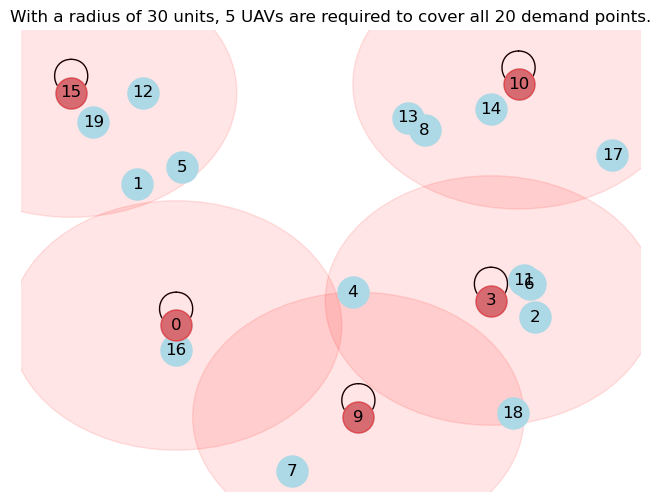

In [375]:
solution = []
if model.status == gb.GRB.OPTIMAL:
    print("Optimization successful.")
    print("Radius: {} units \nUAVs: {} \nDemand points: {}".format(coverage_radius, int(model.objVal), num_demand_points))
    for node in G.nodes():
        if y[node].x > 0.1:
            solution.append(node)
    # Create a new graph for visualization
    graph_visualization = nx.Graph()

    # Add nodes for demand points
    for node, demand_point in enumerate(demand_points):
        graph_visualization.add_node(node, pos=demand_point)

    # Add edges between demand points covered by the solution
    for node in solution:
        # graph_visualization.add_edges_from([(node, n) for n in G.neighbors(node) if n in solution])
        graph_visualization.add_edges_from([(node, n) for n in G.nodes() if x[node, n].x > 0.5])

    # Draw the graph
    pos = nx.get_node_attributes(graph_visualization, 'pos')
    fig, ax = plt.subplots(figsize=figsize)  # Adjust the figure size as desired
    nx.draw(graph_visualization, pos, node_color='lightblue', ax=ax, node_size=node_size)


    # Highlight the demand points covered by the solution
    nx.draw_networkx_labels(graph_visualization, pos, font_size=label_font_size)
    nx.draw_networkx_nodes(graph_visualization, pos, nodelist=solution, node_color='r', alpha=0.5, ax=ax, node_size=node_size)

    # Draw circles for coverage radius for covered demand points only
    for node in solution:
        if node in graph_visualization.nodes():
            x, y = pos[node]
            circle = plt.Circle((x, y), coverage_radius, alpha=0.1, color='r')
            ax.add_artist(circle)

    plt.title("With a radius of {} units, {} UAVs are required to cover all {} demand points.".format(coverage_radius, int(model.objVal), num_demand_points))
    plt.show()
else:
    print("No feasible solution found. Optimization status:", model.status)